# 智能视觉机械臂
   该机械臂为采用树莓派4B为主控，内置逆运动学算法、配备总线舵机及高清晰度摄像头的智能机械臂。通过配合使用OpenCV计算机视觉库，机械臂可以实现图像识别、颜色识别、移动追踪等功能，并通过不同功能的组合来实现能满足实际工作需要的功能。此外，机械臂搭载ROS平台，从而实现了各传感器之间以及各功能模块之间的快速有效通信。
   
   下面我们简要介绍一下机械臂的结构组成、通信方式以及几种基本功能的实现方式。
   以下功能实现操作均在机械臂搭载的树莓派上进行，可先使用Nomachine实现树莓派的远程连接后开始操作。

## 结构组成
机械臂的各部分部件如图所示。

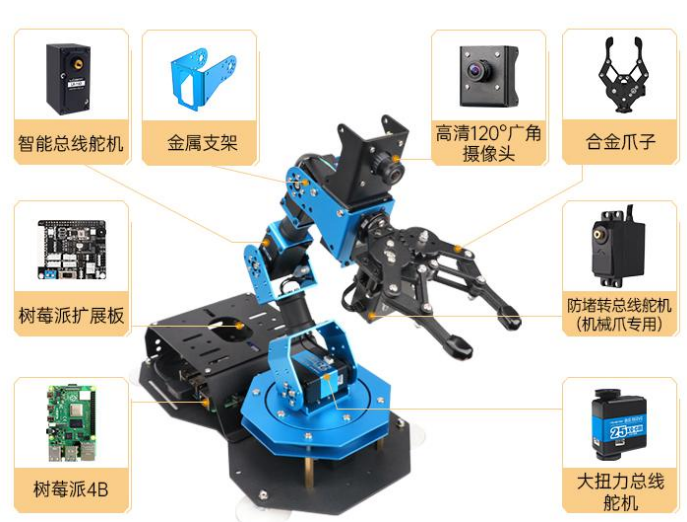

该机械臂包含六部舵机，他们分别用于实现不同功能。
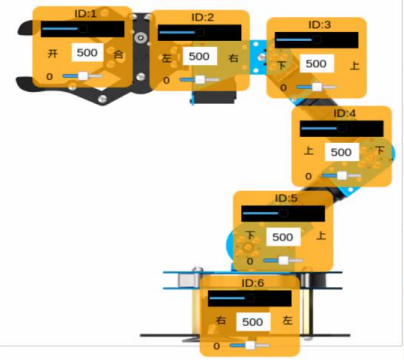
如图所示，各ID对应的舵机实现的功能分别为：
>ID1:机械爪开合 
>ID2:机械爪旋转 
>ID3:机械爪上下摆动 
>ID4:小臂上下摆动 
>ID2:大臂上下摆动 
>ID2:机体旋转 


## ROS通信

Ros 系统是适用于机器人的开源操作系统。提供类似于操作系统的服务，包括硬件抽象描述、底层驱动程序管理、共用功能的执行、程序间消息传递、程序发行包管理，它也提供一些工具和库用于获取、建立、编写和执行多机融合的程序。

话题通信是ROS中使用频率最高的一种通信模式，话题通信是基于发布订阅模式的，也即:一个节点发布消息，另一个节点订阅该消息。这里以控制机械臂上的蜂鸣器为例，演示话题通信的流程。

首先编写代码，构建发布方，每隔一秒发布一次让蜂鸣器鸣响0.5秒的消息。

In [ ]:
#! /usr/bin/env python
import rospy
from std_msgs.msg import *

if __name__ == "__main__":
    #1.初始化 ROS 节点:命名(唯一)
    rospy.init_node("sensorpub")
    #2.实例化 发布者 对象
    buzzer_pub = rospy.Publisher('buzzer', Float32, queue_size=1)
    #3.组织被发布的数据，并编写逻辑发布数据
    # 设置循环频率
    rate = rospy.Rate(1)

    while not rospy.is_shutdown():
        buzzer_pub.publish(0.5)
        rate.sleep()

完成发布方构建后，再来构建订阅方，订阅发布方发出的消息，并将消息内容传给控制蜂鸣器电平的回调函数。

In [ ]:
#! /usr/bin/env python
import rospy
import RPi.GPIO as GPIO
from std_msgs.msg import *

GPIO.setwarnings(False)
GPIO.setmode(GPIO.BCM)
#回调函数（控制蜂鸣器引脚电平）
def setBuzzer(msg):
    GPIO.setup(6, GPIO.OUT)
    GPIO.output(6, 1)
    rospy.sleep(msg.data)
    GPIO.setup(6, GPIO.OUT)
    GPIO.output(6, 0)

    
if __name__ == '__main__':
    #1.初始化 ROS 节点:命名(唯一)
    rospy.init_node('sensorsub') 
    #2.实例化 订阅者 对象
    buzzer_sub = rospy.Subscriber("buzzer", Float32, setBuzzer)
    #3.循环调用回调函数
    rospy.spin()

通过运行这两个节点，可以听到蜂鸣器按照设定的频率鸣响。

## 基本功能
以下功能实现操作均在机械臂搭载的树莓派上进行，可先使用Nomachine实现树莓派的远程连接后开始操作。

### 颜色追踪

#### 实验原理
   首先需要对颜色进行识别，我们使用 Lab 颜色空间来进行处理。先将 RGB 颜色空间转换为 Lab，然后进行二值化处理，再经过膨胀腐蚀等操作，可获得只包含目标颜色的轮廓，再将该颜色轮廓用圆圈框起，便可实现物体颜色的识别。接着在识别到后对机械臂高度部分进行处理，以图像的中心点的 x、y、z 坐标作为设定值，以当前获取的 x、y、z 坐标作为输入值进行更新 pid。然后会根据图像位置的反馈进行计算，最后通过位置的变化使坐标数值进行线性变化，从而达到追踪的效果。
   
#### 操作流程
通过No Machine连接树莓派，在Applications中选择Terminal Emulator打开终端工具。
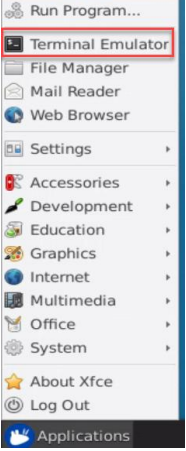
在终端中输入指令“rosservice call /object_tracking/enter "{}"”，然后按下回车进入物品追踪功能。当成功进入后，会出现打印提示，如下图所示：
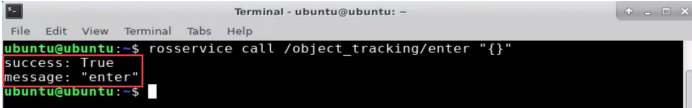
不要关闭当前终端，打开一个新的终端，输入“rqt_image_view”，按下回车，稍等片刻即可打开 rqt 工具
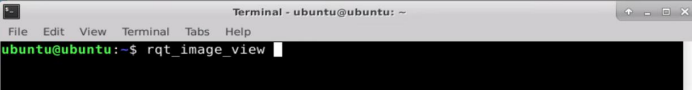
在图示位置选择颜色追踪的话题选项（topic），选项为“/object_tracking/image_result”，其余设置保持不变
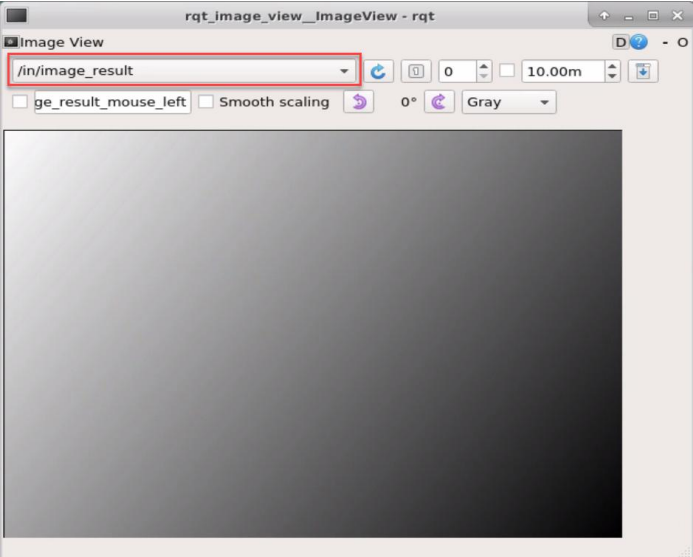
返回第一个终端，输入指令“rosservice call/object_tracking/set_running "data: true"”，同理出现下图所框提示即为启动成功。
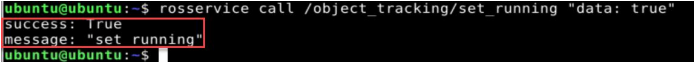
需要设置要追踪的目标颜色，以红色为例，输入“rosservice call /object_tracking/set_target "data: 'red'"”。
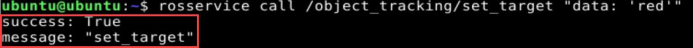
此时，将红色方块移动至摄像头范围内，可在rqt工具内看到目标物体被框出。若缓慢移动物块，机械臂可跟随目标移动。
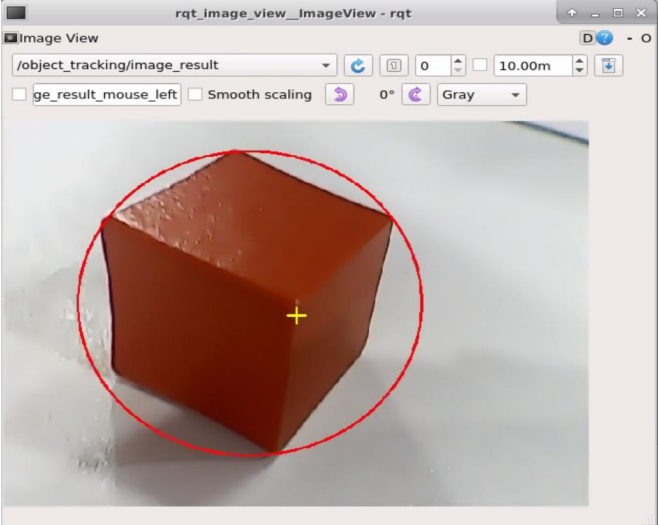

程序源代码如下:

In [ ]:
#!/usr/bin/python3
# coding=utf8

import sys
import cv2
import math
import rospy
import numpy as np
from threading import RLock, Timer

from std_srvs.srv import *
from sensor_msgs.msg import Image

from sensor.msg import Led
from object_tracking.srv import *
from hiwonder_servo_msgs.msg import MultiRawIdPosDur

from kinematics import ik_transform

from armpi_fpv import PID
from armpi_fpv import Misc
from armpi_fpv import bus_servo_control

# 颜色跟踪

ik = ik_transform.ArmIK()

lock = RLock()

size = (320, 240)
start_move = True
__target_color = ''
__isRunning = False
org_image_sub_ed = False

x_dis = 500
y_dis = 0.167
Z_DIS = 0.2
z_dis = Z_DIS
x_pid = PID.PID(P=0.06, I=0.005, D=0)  # pid初始化
y_pid = PID.PID(P=0.00001, I=0, D=0)
z_pid = PID.PID(P=0.00003, I=0, D=0)

range_rgb = {
    'red': (0, 0, 255),
    'blue': (255, 0, 0),
    'green': (0, 255, 0),
    'black': (0, 0, 0),
    'white': (255, 255, 255),
}

# 找出面积最大的轮廓
# 参数为要比较的轮廓的列表
def getAreaMaxContour(contours):
    contour_area_temp = 0
    contour_area_max = 0
    area_max_contour = None

    for c in contours:  # 历遍所有轮廓
        contour_area_temp = math.fabs(cv2.contourArea(c))  # 计算轮廓面积
        if contour_area_temp > contour_area_max:
            contour_area_max = contour_area_temp
            if contour_area_temp > 10:  # 只有在面积大于300时，最大面积的轮廓才是有效的，以过滤干扰
                area_max_contour = c

    return area_max_contour, contour_area_max  # 返回最大的轮廓

# 初始位置
def initMove(delay=True):
    with lock:
        target = ik.setPitchRanges((0, y_dis, Z_DIS), -90, -92, -88)
        if target:
            servo_data = target[1]
            bus_servo_control.set_servos(joints_pub, 1500, ((1, 200), (2, 500), (3, servo_data['servo3']), (4, servo_data['servo4']), (5, servo_data['servo5']),(6, servo_data['servo6'])))
    if delay:
        rospy.sleep(2)

def turn_off_rgb():
    led = Led()
    led.index = 0
    led.rgb.r = 0
    led.rgb.g = 0
    led.rgb.b = 0
    rgb_pub.publish(led)
    led.index = 1
    rgb_pub.publish(led)

# 变量重置
def reset():
    global x_dis, y_dis, z_dis
    global __target_color
    
    with lock:
        x_dis = 500
        y_dis = 0.167
        z_dis = Z_DIS
        x_pid.clear()
        y_pid.clear()
        z_pid.clear()
        turn_off_rgb()
        __target_color = ''

color_range = None
# app初始化调用
def init():
    global color_range 
    
    rospy.loginfo("object tracking Init")
    color_range = rospy.get_param('/lab_config_manager/color_range_list', {})  # get lab range from ros param server
    initMove()
    reset()

def run(img):
    global start_move
    global x_dis, y_dis, z_dis

    img_copy = img.copy()
    img_h, img_w = img.shape[:2]

    cv2.line(img, (int(img_w / 2 - 10), int(img_h / 2)), (int(img_w / 2 + 10), int(img_h / 2)), (0, 255, 255), 2)
    cv2.line(img, (int(img_w / 2), int(img_h / 2 - 10)), (int(img_w / 2), int(img_h / 2 + 10)), (0, 255, 255), 2)

    frame_resize = cv2.resize(img_copy, size, interpolation=cv2.INTER_NEAREST)
    frame_lab = cv2.cvtColor(frame_resize, cv2.COLOR_BGR2LAB)  # 将图像转换到LAB空间

    area_max = 0
    area_max_contour = 0
    
    if __target_color in color_range:
        target_color_range = color_range[__target_color]
        frame_mask = cv2.inRange(frame_lab, tuple(target_color_range['min']), tuple(target_color_range['max']))  # 对原图像和掩模进行位运算
        eroded = cv2.erode(frame_mask, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))  # 腐蚀
        dilated = cv2.dilate(eroded, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))  # 膨胀
        contours = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]  # 找出轮廓
        area_max_contour, area_max = getAreaMaxContour(contours)  # 找出最大轮廓

    if area_max > 100:  # 有找到最大面积
        (center_x, center_y), radius = cv2.minEnclosingCircle(area_max_contour)  # 获取最小外接圆
        center_x = int(Misc.map(center_x, 0, size[0], 0, img_w))
        center_y = int(Misc.map(center_y, 0, size[1], 0, img_h))
        radius = int(Misc.map(radius, 0, size[0], 0, img_w))
        if radius > 100:
            return img
        cv2.circle(img, (int(center_x), int(center_y)), int(radius), range_rgb[__target_color], 2)
        if start_move:
            x_pid.SetPoint = img_w / 2.0  # 设定
            x_pid.update(center_x)  # 当前
            dx = x_pid.output
            x_dis += int(dx)  # 输出

            x_dis = 200 if x_dis < 200 else x_dis
            x_dis = 800 if x_dis > 800 else x_dis

            y_pid.SetPoint = 900  # 设定
            if abs(area_max - 900) < 50:
                area_max = 900
            y_pid.update(area_max)  # 当前
            dy = y_pid.output
            y_dis += dy  # 输出
            y_dis = 0.12 if y_dis < 0.12 else y_dis
            y_dis = 0.25 if y_dis > 0.25 else y_dis

            z_pid.SetPoint = img_h / 2.0
            z_pid.update(center_y)
            dy = z_pid.output
            z_dis += dy

            z_dis = 0.22 if z_dis > 0.22 else z_dis
            z_dis = 0.17 if z_dis < 0.17 else z_dis

            target = ik.setPitchRanges((0, round(y_dis, 4), round(z_dis, 4)), -90, -85, -95)
            if target:
                servo_data = target[1]
                bus_servo_control.set_servos(joints_pub, 20, (
                    (3, servo_data['servo3']), (4, servo_data['servo4']), (5, servo_data['servo5']), (6, x_dis)))
    return img

def image_callback(ros_image):
    global lock
    
    image = np.ndarray(shape=(ros_image.height, ros_image.width, 3), dtype=np.uint8,
                       buffer=ros_image.data)  # 将自定义图像消息转化为图像
    cv2_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    frame = cv2_img.copy()
    frame_result = frame
    with lock:
        if __isRunning:
            frame_result = run(frame)
    rgb_image = cv2.cvtColor(frame_result, cv2.COLOR_BGR2RGB).tostring()
    ros_image.data = rgb_image
    
    image_pub.publish(ros_image)

def enter_func(msg):
    global lock
    global image_sub
    global __isRunning
    global org_image_sub_ed
    
    rospy.loginfo("enter object tracking")
    init()
    with lock:
        if not org_image_sub_ed:
            org_image_sub_ed = True
            image_sub = rospy.Subscriber('/usb_cam/image_raw', Image, image_callback)
            
    return [True, 'enter']

heartbeat_timer = None
def exit_func(msg):
    global lock
    global image_sub
    global __isRunning
    global org_image_sub_ed
    
    rospy.loginfo("exit object tracking")
    with lock:
        __isRunning = False
        reset()
        try:
            if org_image_sub_ed:
                org_image_sub_ed = False
                heartbeat_timer.cancel()
                image_sub.unregister()
        except BaseException as e:
            rospy.loginfo('%s', e)
        
    return [True, 'exit']

def start_running():
    global lock
    global __isRunning
    
    rospy.loginfo("start running object tracking")
    with lock:
        __isRunning = True

def stop_running():
    global lock
    global __isRunning
    
    rospy.loginfo("stop running object tracking")
    with lock:
        __isRunning = False
        reset()
        initMove(delay=False)

def set_running(msg):
    if msg.data:
        start_running()
    else:
        stop_running()
        
    return [True, 'set_running']

def set_target(msg):
    global lock
    global __target_color
    
    rospy.loginfo("%s", msg)
    with lock:
        __target_color = msg.data
        led = Led()
        led.index = 0
        led.rgb.r = range_rgb[__target_color][2]
        led.rgb.g = range_rgb[__target_color][1]
        led.rgb.b = range_rgb[__target_color][0]
        rgb_pub.publish(led)
        led.index = 1
        rgb_pub.publish(led)
        rospy.sleep(0.1)
        
    return [True, 'set_target']

def heartbeat_srv_cb(msg):
    global heartbeat_timer

    if isinstance(heartbeat_timer, Timer):
        heartbeat_timer.cancel()
    if msg.data:
        heartbeat_timer = Timer(5, rospy.ServiceProxy('/object_tracking/exit', Trigger))
        heartbeat_timer.start()
    rsp = SetBoolResponse()
    rsp.success = msg.data

    return rsp


if __name__ == '__main__':
    rospy.init_node('object_tracking', log_level=rospy.DEBUG)
    
    joints_pub = rospy.Publisher('/servo_controllers/port_id_1/multi_id_pos_dur', MultiRawIdPosDur, queue_size=1)
    
    image_pub = rospy.Publisher('/object_tracking/image_result', Image, queue_size=1)  # register result image publisher

    rgb_pub = rospy.Publisher('/sensor/rgb_led', Led, queue_size=1)
    
    enter_srv = rospy.Service('/object_tracking/enter', Trigger, enter_func)
    exit_srv = rospy.Service('/object_tracking/exit', Trigger, exit_func)
    running_srv = rospy.Service('/object_tracking/set_running', SetBool, set_running)
    set_target_srv = rospy.Service('/object_tracking/set_target', SetTarget, set_target)
    heartbeat_srv = rospy.Service('/object_tracking/heartbeat', SetBool, heartbeat_srv_cb)

    debug = False
    if debug:
        rospy.sleep(0.2)
        enter_func(1)
        
        msg = SetTarget()
        msg.data = 'blue'
        
        set_target(msg)
        start_running()

    try:
        rospy.spin()
    except KeyboardInterrupt:
        rospy.loginfo("Shutting down")
    finally:
        cv2.destroyAllWindows()


### 人脸追踪
#### 实验原理
   首先，我们先初始化并开启摄像头，通过摄像头获取当前画面图像。再使用 caffe 训练好的卷积神经网络人脸模型的人脸识别库，把模型放置到指定的路径下，通过 OpenCV 的函数进行调用。
   
接着，我们定义一个变量，用来存放阈值。再计算当前检测到的人脸，与人脸识别库的所有用户面部特征对比的相似度，得到置信度值。当置信度值大于阈值时，我们将人脸坐标转换为未缩放前坐标，将人脸框出。

最后，我们计算出人脸的中心点实时坐标，以此来更新 PID 数值，再经过逆运动学求解获得各个舵机的转动角度从而控制机械臂完成追踪。

#### 操作流程
通过No Machine连接树莓派，在Applications中选择Terminal Emulator打开终端工具。
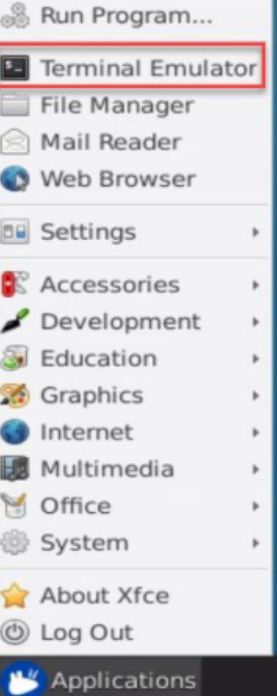
在终端中输入进入玩法程序所在目录的指令“cd Ai_FPV/”，按下回车。
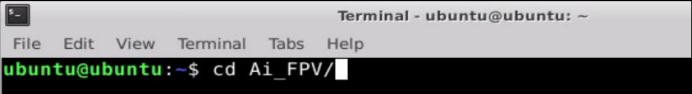
输入运行玩法程序的指令“sudo python3 FaceTrack.py”，按下回车键。
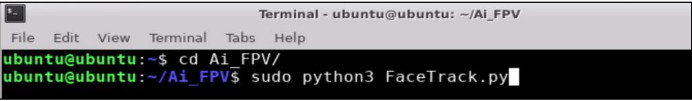
程序运行后，机械臂切换为人脸追踪姿态。当摄像头检测到人脸后，机械臂跟随人脸的移动而运动，同时回传画面中会将识别到的人脸圈出。
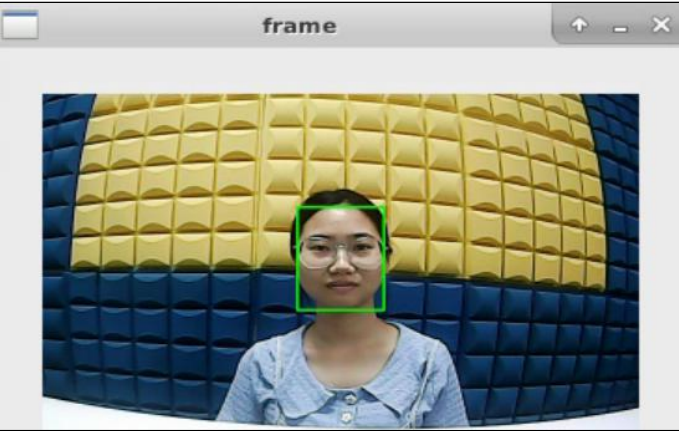
程序源代码如下：

In [ ]:
#!/usr/bin/python3
# coding=utf8
import sys
import cv2
import math
import time
import threading
import numpy as np
import HiwonderSDK.Board as Board
import HiwonderSDK.PID as PID
import HiwonderSDK.Misc as Misc
from ArmIK.Transform import *
from ArmIK.ArmMoveIK import *

# 人脸检测
if sys.version_info.major == 2:
    print('Please run this program with python3!')
    sys.exit(0)

AK = ArmIK()

x_dis = 500
y_dis = 10
Z_DIS = 18
z_dis = Z_DIS
x_pid = PID.PID(P=0.15, I=0.00, D=0.01)  # pid初始化
y_pid = PID.PID(P=0.00001, I=0, D=0)
z_pid = PID.PID(P=0.005, I=0, D=0)
    
# 初始位置
def initMove():
    Board.setBusServoPulse(1, 500, 800)
    Board.setBusServoPulse(2, 500, 800)
    AK.setPitchRangeMoving((0, y_dis, z_dis), 0,-90, 0, 1500)

# 阈值
conf_threshold = 0.6
# 模型位置
modelFile = "./models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "./models/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

frame_pass = True
x1=x2=y1=y2 = 0
old_time = 0
st = True

def run(img):
    global st 
    global old_time
    global frame_pass
    global x1,x2,y1,y2
    global x_dis, y_dis, z_dis
    
    if not frame_pass:
        frame_pass = True
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2, 8)
        x1=x2=y1=y2 = 0
        return img
    else:
        frame_pass = False
        
    img_copy = img.copy()
    img_h, img_w = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img_copy, 1, (150, 150), [104, 117, 123], False, False)
    net.setInput(blob)
    detections = net.forward() #计算识别
    
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            #识别到的人了的各个坐标转换会未缩放前的坐标
            x1 = int(detections[0, 0, i, 3] * img_w)
            y1 = int(detections[0, 0, i, 4] * img_h)
            x2 = int(detections[0, 0, i, 5] * img_w)
            y2 = int(detections[0, 0, i, 6] * img_h)             
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2, 8) #将识别到的人脸框出
##            area_max = int(abs((x2-x1)*(y2-y1)))
            
            X = (x1 + x2)/2
            Y = (y1 + y2)/2
            
            x_pid.SetPoint = img_w / 2.0  # 设定
            x_pid.update(X)  # 当前
            dx = x_pid.output
            x_dis += int(dx)  # 输出

            x_dis = 0 if x_dis < 0 else x_dis
            x_dis = 1000 if x_dis > 1000 else x_dis

            
            if abs(Y - img_h/2.0) < 20:
                z_pid.SetPoint = Y
            else:
                z_pid.SetPoint = img_h / 2.0
                
            z_pid.update(Y)
            dy = z_pid.output
            z_dis += dy

            z_dis = 40.00 if z_dis > 40.00 else z_dis
            z_dis = 10.00 if z_dis < 8.00 else z_dis
            
            target = AK.setPitchRange((0, round(y_dis, 2), round(z_dis, 2)), -5, 10)
            
            if target:
                servo_data = target[0]
                if st:
                    Board.setBusServoPulse(3, servo_data['servo3'], 1000)
                    Board.setBusServoPulse(4, servo_data['servo4'], 1000)
                    Board.setBusServoPulse(5, servo_data['servo5'], 1000)
                    time.sleep(1)
                    st = False
                else:
                    Board.setBusServoPulse(3, servo_data['servo3'], 20)
                    Board.setBusServoPulse(4, servo_data['servo4'], 20)
                    Board.setBusServoPulse(5, servo_data['servo5'], 20)
                    
            Board.setBusServoPulse(6, int(x_dis), 20)
            time.sleep(0.03)
       
    return img

if __name__ == '__main__':
    initMove()
    cap = cv2.VideoCapture(-1) #读取摄像头
    
    while True:
        ret, img = cap.read()
        if ret:
            frame = img.copy()
            Frame = run(frame)           
            frame_resize = cv2.resize(Frame, (320, 240))
            cv2.imshow('frame', frame_resize)
            key = cv2.waitKey(1)
            if key == 27:
                break
        else:
            time.sleep(0.01)
    cv2.destroyAllWindows()